In [1]:
%env SKLEARN_SITE_JOBLIB=1
# https://github.com/scikit-learn/scikit-learn/issues/10533
# https://github.com/scikit-learn/scikit-learn/issues/12250
# %env LOKY_PICKLER='cloudpickle' 
# import multiprocessing
# multiprocessing.set_start_method('forkserver')
# import cloudpickle

env: SKLEARN_SITE_JOBLIB=1


In [2]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

new_filename = "final_project_dataset_PROVEN.pkl"
exec(open("poi_id.py").read())

# Udacity Final Project: Identify Fraud from Enron Email

> Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

- ***POI***: an individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.



## Overview of the Dataset and Removal of Outliers
The job of every good Data Analysts starts by understanding the task and the provided datasets.
This is a sample of the dataset in the form of a (Pandas-)table to illustrate the structure of the dataset.

In [2]:
print("Number of records: {}".format(len(data_dict_raw)))

Number of records: 146


In [3]:
print("Number of parameters: {}".format(len(df.columns)))

Number of parameters: 21


### List of parameters:

In [4]:
df.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

The label `POI` indicates, if a person has been identified as a ***Person Of Interest***. The other parameters provide information about salary, stock value and E-mail communication.

## Financial Data
The document `enron61702insiderpay.pdf` contains all the data and documentation.

![Enron Insider Pay](enron61702insiderpay_snap.png)

### Payments
1. `salary` Reflects items such as base salary, executive cash allowances, and benefits payments.
- `bonus`Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
- `long_term_incentive` Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
- `deferred_income` Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
- `deferral payments` Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
- `loan_advances` Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.
- `other` Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
- `expenses` Reflects reimbursements of business expenses. May include fees paid for consulting services.
- `director_fees` Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

### Stock Value
10. `exercised_stock_options` Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities.
- `restricted_stock` Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.
- `restricted_stock_deferred` Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.


## E-mail data
Some metadata about the E-mail communication of these persons is provided too:

In [5]:
print(features_email_stats)

['from_messages', 'from_this_person_to_poi', 'to_messages', 'from_poi_to_this_person', 'shared_receipt_with_poi']


## Quality Check of the Provided Dataset
Regarding the financial data, the parameters `total_payments` and `total_stock_value` may serve as a kind of checksum, i.e. to ensure the integrity of the dataset.

Unfortunately, there are at least

In [6]:
def checksum_df(df, cols, expected_sum):
    """Returns all rows that do not match expected_sum"""
    df[expected_sum[0]] = df[expected_sum[0]].fillna(0.0)
    df_wrong_checksum = df[df[cols].sum(axis=1)!=df[expected_sum[0]]]
    df_wrong_checksum = df_wrong_checksum[cols+expected_sum]
    df_wrong_checksum = df_wrong_checksum[df_wrong_checksum.any(axis=1)]
    return df_wrong_checksum

df_salary_wrong_checksum = checksum_df(df, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum))

2


rows, where `total_payments` does not sum up to the expected value.

These are the rows:

In [7]:
HTML(df_salary_wrong_checksum.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0


The same problem is present for the `total_stock_value`, for this number of rows:

In [8]:
df_stock_wrong_checksum = checksum_df(df, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum))

2


This table is showing the corrupt rows:

In [9]:
HTML(df_stock_wrong_checksum.head(5).to_html())

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285.0,NaN,44093.0,-44093.0
BHATNAGAR SANJAY,2604490.0,-2604490.0,15456290.0,0.0


Obviously, the quality of the provided data cannot be trusted. There may be two reasons for this:
1. The original data is already corrupt.
- The provided derived dataset `final_project_dataset.pkl` is corrupt due to human mistake.

In case of human mistake, it is possible to check the values in `enron61702insiderpay.pdf`.
Apparently, the original document has different values for the suspicious records. So there is at least a few obvious human errors.

However, there might be many more errors, although the checksum is correct.

## Correction of the provided input dataset
In order to correct human error in the process, it is neccessary to compare the dataset row by row.

### Parsing the full table from `enron61702insiderpay.pdf`
is required, since this is the original document.

In [10]:
import re
import numpy as np

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
has_numbers_re = re.compile(r'[0-9]+')

# INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z])|(^[A-Z]+, [A-Z]+)')
INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z .]+)|(^[A-Z-]+, [A-Z]+)')
FOOTNOTE_re = re.compile(r'^\([a-z]\)')
NUMBER_re = re.compile(r'(^\(\$([0-9,_]+)\))|(^\(([0-9,_]+)\))|(^\$[0-9,]+)|(^[0-9,]+)')
# SPACES_re = re.compile(r'[^\S\n\t]+') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only
SPACES_re = re.compile(r'^\ ') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only

tablestr = "ALLEN, PHILLIP K   $1233,43423  ($999,9) $324,001BADUM JR., JAMES P  25,234,000 (d) (21,123) 435,325,455BERBERIAN, DAVID 235,111"

def check_re(robj, s):
    m = robj.search(s)
    if m:
        name = m.group()
        return name
    else:
        return None

def parse_row(s):
    rowelements = []
    row_incomplete = True
    space = 0
    while row_incomplete:
        footnote = check_re(FOOTNOTE_re, s)
        number = check_re(NUMBER_re, s)        
        if not s:
            break
        if s[0] == ' ':
            s = s.split(' ', 1)[1]
            space += 1
        elif footnote:
            s = s.split(footnote, 1)[1]
        elif number:
            s = s.split(number, 1)[1]
            number = float(int(number.replace("$","").replace(",","").replace("(","").replace(")","")))
            rowelements.append(number)
            #print(space)
            space = 0
        elif s[0] == '-':
            s = s.split('-', 1)[1]
            rowelements.append(np.nan)
            #print(space)
            space = 0            
        else:
            row_incomplete = False
    new_s = s
    return new_s, rowelements

def parse_table(tablestr):
    d = {}
    table_incomplete = True
    while table_incomplete:
        n = check_re(INSIDERNAME_re, tablestr)
        if n:
            #print("name found: {}".format(n))
            tablestr = tablestr.split(n, 1)[1]
            tablestr, row = parse_row(tablestr)
            if row:
                n = n.replace(",","").replace(".","")
                d.update({n:row})
            else:
                table_incomplete = False
            #print(tablestr)
        else:
            table_incomplete = False
    return d

# For testing the functions
#dd = parse_table(tablestr)
#print(tablestr)
#print(dd)


In [11]:
# https://automatetheboringstuff.com/chapter13/
import PyPDF2

pdfReader = PyPDF2.PdfFileReader(open('enron61702insiderpay.pdf', 'rb'))
pages = [0,1,2,3]
data_dict = {}
for page in pages:
    print("Parsing page #{}...".format(page))
    pageObj = pdfReader.getPage(page)
    text = pageObj.extractText()
    table = text.split("Total Stock Value",1)[1]
    dd = parse_table(table)
    data_dict.update(dd)

Parsing page #0...
Parsing page #1...
Parsing page #2...
Parsing page #3...


In [12]:
cols = features_financial_salary + features_financial_salary_total + features_financial_stock + features_financial_stock_total
df_pdf = pd.DataFrame.from_dict(data_dict, columns=cols, orient='index')
# Deferral items are negative...
df_pdf['deferred_income'] = -df_pdf['deferred_income']
df_pdf['restricted_stock_deferred'] = -df_pdf['restricted_stock_deferred']
#df_pdf['deferral_payments'] = -df_pdf['deferral_payments']

In [13]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

2


In [14]:
HTML(df_salary_wrong_checksum_pdf.to_html())


,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0
YEAP SOON,NaN,55097.0,NaN,-55097.0,192758.0,NaN,NaN,192758.0,NaN,0.0


In [15]:
print(df_salary_wrong_checksum_pdf.to_csv())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,,,,,,,137864.0,,137864.0,15456290.0
YEAP SOON,,55097.0,,-55097.0,192758.0,,,192758.0,,0.0



The few suspicious rows are due to missing delimiters in the original document.

The values are corrected "by hand". The number of incorrect checksum is now for `features_financial_salary_total`:

In [16]:
ff = features_financial_salary+features_financial_salary_total + features_financial_stock + features_financial_stock_total

In [17]:
bs=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,137864.0, np.nan,137864.0, 15456290.0, 2604490.0, -2604490.0, 15456290.0]
ys = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 55097.0, np.nan, 55097.0, 192758.0, np.nan, np.nan, 192758.0]
df_pdf.loc['BHATNAGAR SANJAY'] = pd.Series(bs, index=ff)
df_pdf.loc['poi', 'BHATNAGAR SANJAY'] = 0.0
df_pdf.loc['YEAP SOON'] = pd.Series(ys, index=ff)

In [18]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

0


and for `features_financial_stock_total`:

In [19]:
df_stock_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum_pdf))

0


Finally, the following table shows all the rows from the new self-parsed dataset that are different from the provided dataset. There are apparently 9 differences in a dataset of less than 150 records. However, a few are just the names that was parsed in a different way.

In [20]:
# https://stackoverflow.com/questions/19917545/comparing-two-pandas-dataframes-for-differences
def get_different_rows(source_df, new_df):
    """Returns just the rows from the new dataframe that differ from the source dataframe"""
    merged_df = source_df.merge(new_df, indicator=True, how='outer')
    changed_rows_df = merged_df[merged_df['_merge'] == 'right_only']
    return changed_rows_df.drop('_merge', axis=1)
#features_financial_salary+features_financial_salary_total #

df1 = df[ff].reset_index()
df2 = df_pdf[ff].reset_index()#.drop('index', axis=1)
df_diff12 = get_different_rows(df1, df2)
df_diff21 = get_different_rows(df2, df1)

HTML(df_diff12.to_html())

,index,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
146,BAXTER JOHN C,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0
147,BELFER ROBERT A,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0
148,BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0
149,BLAKE JR NORMAN P,NaN,NaN,NaN,-113784.0,NaN,NaN,NaN,1279.0,113784.0,1279.0,NaN,NaN,NaN,0.0
150,DERRICK JR JAMES V,492375.0,800000.0,484000.0,-1284000.0,NaN,NaN,7482.0,51124.0,NaN,550981.0,8831913.0,1787380.0,-1787380.0,8831913.0
151,LAY KENNETH L,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,NaN,103559793.0,34348384.0,14761694.0,NaN,49110078.0
152,PEREIRA PAULO V FERRAZ,NaN,NaN,NaN,-101250.0,NaN,NaN,NaN,27942.0,101250.0,27942.0,NaN,NaN,NaN,0.0
153,WINOKUR JR HERBERT S,NaN,NaN,NaN,-25000.0,NaN,NaN,NaN,1413.0,108579.0,84992.0,NaN,NaN,NaN,0.0
154,poi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


Most of the differences are due to inconsistently parsed names. However, there are only 2 rows with wrong numbers (which was at least expected). The correct numbers are shown in the following table:

In [21]:
df1 = df[ff].reset_index().drop('index', axis=1)
df_diff12n = get_different_rows(df1, df2)
HTML(df_diff12n.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,index
147,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0,BELFER ROBERT A
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,BHATNAGAR SANJAY


From the perspective of the provided dataset (final_project_dataset.pkl), the following additional rows are corrected:

In [22]:
df1 = df[ff].reset_index()
df2 = df_pdf[ff].reset_index().drop('index', axis=1)
df_diff21 = get_different_rows(df2, df1)
HTML(df_diff21.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,index
145,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,BELFER ROBERT
146,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,BHATNAGAR SANJAY
147,NaN,NaN,NaN,NaN,NaN,NaN,362096.0,NaN,NaN,362096.0,NaN,NaN,NaN,0.0,THE TRAVEL AGENCY IN THE PARK
148,26704229.0,97343619.0,48521928.0,-27992891.0,32083396.0,83925000.0,42667589.0,5235198.0,1398517.0,309886585.0,311764000.0,130322299.0,-7576788.0,434509511.0,TOTAL


*THE TRAVEL AGENCY IN THE PARK* and *TOTAL* are appently no persons and are removed from the records.

A further inconsistency was found by chance: *FREVERT MARK A* is listed as a *POI* in the second table, but not in the first one. Lacking further information, it is decided to handle him as a *POI* as well, because his payments / stock value is in the same order of magnitude of the other *POI's*.

In [23]:
df_pdf[df_pdf.index.isin(['FREVERT MARK A'])]

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,BHATNAGAR SANJAY
FREVERT MARK A,1060932.0,2000000.0,1617011.0,-3367011.0,6426990.0,2000000.0,7427621.0,86987.0,NaN,17252530.0,10433518.0,4188667.0,NaN,14622185.0,NaN


The corrected dataset is saved to `final_project_dataset_PROVEN.pkl` and will be used from now.

In [24]:
bs = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,137864.0, np.nan,137864.0, 15456290.0, 2604490.0, -2604490.0, 15456290.0]
ys = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 55097.0, np.nan, 55097.0, 192758.0, np.nan, np.nan, 192758.0]
df.loc['BHATNAGAR SANJAY'] = pd.Series(bs, index=ff)
df.loc['BHATNAGAR SANJAY','poi'] = 0
df.loc['YEAP SOON'] = pd.Series(ys, index=ff)
df.loc['FREVERT MARK A','poi'] = 1
df.loc['BELFER ROBERT', ff] = df_pdf.loc['BELFER ROBERT A', ff]
try:
    df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)
except:
    print("Drop already done...")

In [25]:
df.loc['BHATNAGAR SANJAY', 'poi']

0.0

In [27]:
df.to_pickle(new_filename)

## Considerations...
- "Director Fees" have never received by a POI
- "Persons that have gotten a director fee, have never gotten a salary or bonus
- Except for one case, a POI has always a salary
- POI's have a high fraction of exercised stock options
- deferred_income and
- `restricted_stock` Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
- `restricted_stock_deferred` is the part of the restricted_stock, that a person has most likely never gotten because Enron went into bancrupcy before.
- `Expenses` are likely unimportant
- **Cascade/Pipeline decision tree with other stuff** SEE sklearn.ensembles

## Engineering new features
Sometimes numbers are less important than relations or proportions to an aggregated value.
One example is the value of `restricted_stock_deferred`, which is the part of a persons stock value that its owner has certainly lost when Enron went into bankrupcy. More interesting would be the relation of lost stock value to the total stock value. As a hypothesis, POI's would likely have lost a very small proportion of its total stock value because the are certainly well informed about the state of the company.

In [3]:
df = pd.read_pickle(new_filename)
df = df.replace(np.nan, 0.0)

In [4]:
# Relevant and engineered features due to "engineering judgement"
# gotten versus deferral payments (sum it up)

f = pd.Series(features_financial_salary)
df['total_payments_corr'] = df[f[~f.isin(['deferred_income'])]].sum(axis=1)

f = pd.Series(features_financial_stock)
df['total_stock_value_corr'] = df[f[~f.isin(['restricted_stock_deferred'])]].sum(axis=1)
df['total_cash'] = df['total_payments_corr'] + df['total_stock_value_corr']

df['total_payments_corr'].replace(0.0, 1.0, inplace=True)
df['total_stock_value_corr'].replace(0.0, 1.0, inplace=True)

df['fraction_salary']                    = df['salary']                    / df['total_payments_corr']
df['fraction_bonus']                     = df['bonus']                     / df['total_payments_corr']
df['fraction_long_term_incentive']       = df['long_term_incentive']       / df['total_payments_corr']
df['fraction_deferral_payments']         = df['deferral_payments']          / df['total_payments_corr']

df['fraction_deferred_income']           = df['deferred_income']           / df['total_payments_corr'] # lost cash

df['fraction_exercised_stock_options']   = df['exercised_stock_options']   / df['total_stock_value_corr']
df['fraction_restricted_stock_deferred'] = df['restricted_stock_deferred'] / df['total_stock_value_corr'] # lost stock
df['fraction_restricted_stock']          = df['restricted_stock']          / df['total_stock_value_corr']

df['fraction_employer_direct_cash']  = df['fraction_salary'] + df['fraction_bonus'] + df['fraction_long_term_incentive']
df['fraction_employer_stock_cash']   = df['total_stock_value'] / df['total_stock_value_corr']
df['fraction_director_direct_cash']  = df['director_fees'] / df['total_payments_corr']

#HTML(df[features_financial_salary].describe().T.to_html())
HTML(df.describe().T.to_html())

features_fractions_lost = ['fraction_deferred_income', 'fraction_restricted_stock_deferred']
features_fractions_cash = ['fraction_employer_direct_cash', 'fraction_employer_stock_cash']
features_absolute_cash  = ['total_payments_corr', 'total_stock_value_corr']

In [5]:
# TODO: Remove him for some algos
bigboss = df['total_payments_corr'].idxmax()
print("Big Boss: {}".format(bigboss))

Big Boss: LAY KENNETH L


In [6]:
df['restricted_stock_deferred'].max()

0.0

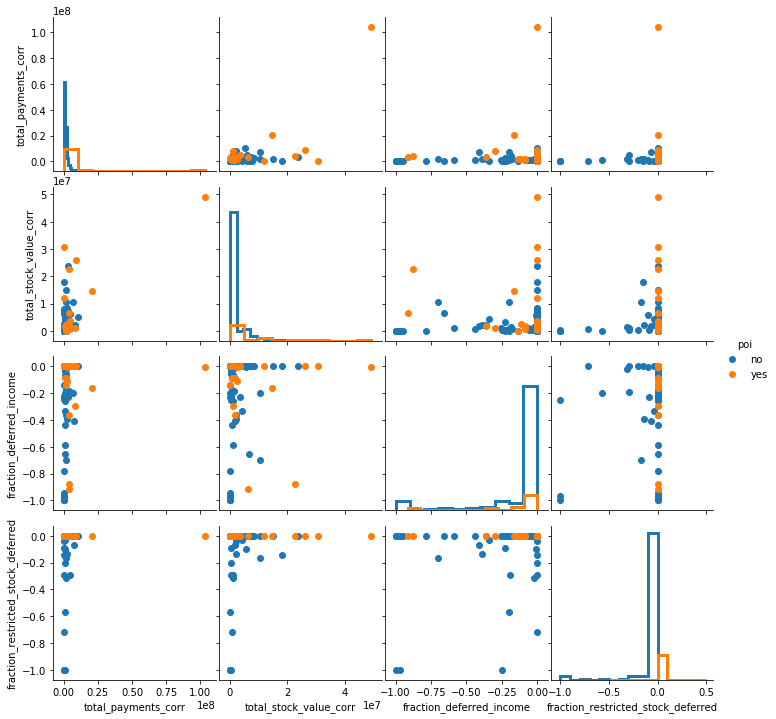

In [7]:
# https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# https://seaborn.pydata.org/tutorial/axis_grids.html
# df = df_pdf
# df = pd.DataFrame.from_dict(my_dataset, orient='index') #.replace('NaN', np.nan) # Load cleaned dataset

df2plot = deepcopy(df)

df2plot['poi'] = df2plot['poi'].replace(True, 'yes')
df2plot['poi'] = df2plot['poi'].replace(False, 'no')
# features2plot = features_financial_salary+features_financial_stock + features_email + ['poi']
features2plot = features_absolute_cash + features_fractions_lost + ['poi']


df2plot = df2plot[features2plot]
#df2plot = df2plot[~(df2plot.isna().sum(axis=1)>0)] # plot only existing data
#g = sns.pairplot(df2plot, hue="poi") # 

g = sns.PairGrid(df2plot, hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns[~df2plot.columns.isin(['poi'])].tolist(), hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns.tolist())
#g = g.map(plt.scatter)
g.fig.subplots_adjust(wspace=.02, hspace=.1);
#g.fig.subplots_adjust(wspace=.02, hspace=.02);
g = g.map_upper(plt.scatter)
g = g.map_diag(plt.hist, histtype="step", linewidth=3)
#g.map_diag(sns.kdeplot, lw=3, legend=False);
#g.map_lower(sns.kdeplot)
g = g.map_lower(plt.scatter)
g.add_legend()
#g.map_offdiag(plt.scatter)


Since the dataset has many features, a relatively small number of records and is additionally pretty sparse, the usual training/testing splitting is not very approproate. Instead, the whole dataset is used for training and cross validation for testing. An appropriate function is `test_classifier()`, which has already been provided by Udacity as part of the module **[tester](tester.py)**.

In [37]:
#df[['poi']+features_fractions_lost].values
#features_list = ['poi']+features_fractions_lost
# features_list = ['poi']+features_fractions_lost+features_absolute_cash
data_d = df.to_dict(orient='index') # Required for Udacitiy's test_classifier
# len(data_d.keys())
df=df.drop(["email_address"], axis=1)

## DecisionTreeClassifier

In [43]:
%%time
# TODO: Zuerst ein paar Features durchprobieren.
pipe = Pipeline([
    ("selector", None),
    ("classifier", DecisionTreeClassifier())
])

param_grid =[
    {
        "selector": [DataFrameSelector()],
        "selector__attribute_names": [features_absolute_cash,
                                  features_absolute_cash+features_fractions_lost,
                                  features_absolute_cash+features_fractions_cash,
                                  features_absolute_cash+features_fractions_lost+features_fractions_cash,
                                  ['total_cash']+features_fractions_lost,
                                  ['total_cash']+['fraction_director_direct_cash']+features_fractions_lost
                                 ],
        "classifier__criterion": ["entropy"],
        "classifier__max_depth": [4,5,6,7,8,9,10],
        "classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    },
    {
        "selector": [PCA()],
        "selector__n_components": [2,3,4,5],
        "classifier__criterion": ["entropy"],
        "classifier__max_depth": [4,5,6,7,8,9,10],
        "classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }
]
# "dt_simple__min_samples_leaf": [1,3,6,8] # Makes it worse

#     "dt_simple__min_samples_leaf": [1,3,6,8]
sss = StratifiedShuffleSplit(n_splits=100, random_state=42)

#if __name__ == '__main__':
#   # parallel code here
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=sss, scoring="recall", n_jobs=-1)
#grid_search = GridSearchCV(clf, param_grid=param_grid, cv=sss, scoring="recall", n_jobs=1)

f = pd.Series(df.columns)
grid_search.fit(df[f[~f.isin(['poi'])]], df['poi'].values)

CPU times: user 16.1 s, sys: 153 ms, total: 16.2 s
Wall time: 16.9 s


In [44]:
#print(grid_search.best_params_)
print(grid_search.best_estimator_)

Pipeline(memory=None,
     steps=[('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_im...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


In [45]:
grid_search.best_score_

0.4

In [46]:
grid_search.verbose

0

In [48]:
grid_search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 9,
 'classifier__min_samples_leaf': 1,
 'selector': PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'selector__n_components': 4}

In [52]:
from tester import test_classifier
#from sklearn.tree import DecisionTreeClassifier # Already imported in poi_id.py
# Training classifiers
#clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
#clf1 = DecisionTreeClassifier(criterion=grid_search.best_params_['dt_simple__criterion'],
#                              max_depth=grid_search.best_params_['dt_simple__max_depth']
#                              )
#  min_samples_leaf=grid_search.best_params_['dt_simple__min_samples_leaf'] # Makes it worse

#clf2 = KNeighborsClassifier(n_neighbors=7)
#clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
#                                    ('svc', clf3)],
#                        voting='soft', weights=[2, 1, 2])

# test_classifier(clf1, data_d, ['poi']+grid_search.best_params_["selector__attribute_names"], folds=1000)
test_classifier(grid_search.best_estimator_, data_d, ['poi']+list(f[~f.isin(['poi', 'email_address'])]), folds=100)

Pipeline(memory=None,
     steps=[('selector', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_im...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.83867	Precision: 0.39706	Recall: 0.40500	F1: 0.40099	F2: 0.40339
	Total predictions: 1500	True positives:   81	False positives:  123	False negatives:  119	True negatives: 1177



In [101]:
from sklearn.tree import export_graphviz
export_graphviz(
    clf1,
    out_file="files/DecisionTreeClassifier.dot",
    feature_names=grid_search.best_params_["selector__attribute_names"], #features_list[1:],
    class_names=["no", "yes"],
    rounded=True,
    filled=True
)

In [102]:
%%bash
dot -Tpng files/test_tree.dot -o files/DecisionTreeClassifier.png

In [103]:
import random
__counter__ = random.randint(0,2e9)
display(HTML('<img src="files/DecisionTreeClassifier.png?%d" alt="Decision tree" height="100">' % __counter__))

## RandomForestClassifier

In [26]:
%%time

#from sklearn.ensemble import RandomForestClassifier
#rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
#rnd_clf.fit(X_train, y_train)
#y_pred_rf = rnd_clf.predict(X_test)

#from sklearn.svm               import LinearSVC
clf = Pipeline([
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ("randomforest", RandomForestClassifier())
])

param_grid =[{
    "randomforest__criterion": ["entropy"],
    "randomforest__n_estimators": [10, 50, 100],
    "randomforest__max_features": [4, 5, 6, 7],
    "randomforest__max_depth": [5, 6, 7, 8, None]
}]




sss = StratifiedShuffleSplit(n_splits=100, random_state=42)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=sss, n_jobs=-1)

f = pd.Series(df.columns)
grid_search.fit(df[f[~f.isin(['poi', 'email_address'])]], df['poi'].values)

CPU times: user 20.4 s, sys: 245 ms, total: 20.6 s
Wall time: 1min 30s


/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
grid_search.best_params_

{'randomforest__criterion': 'entropy',
 'randomforest__max_depth': 5,
 'randomforest__max_features': 4,
 'randomforest__n_estimators': 100}

In [28]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [29]:
%%time
clf2 = RandomForestClassifier(criterion=grid_search.best_params_['randomforest__criterion'],
                              max_depth=grid_search.best_params_['randomforest__max_depth'],
                              max_features=grid_search.best_params_['randomforest__max_features'],
                              n_estimators=grid_search.best_params_['randomforest__n_estimators'])
#clf2 = KNeighborsClassifier(n_neighbors=7)
#clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
#                                    ('svc', clf3)],
#                        voting='soft', weights=[2, 1, 2])

test_classifier(grid_search.best_estimator_, data_d, ['poi']+list(f[~f.isin(['poi', 'email_address'])]), folds=100)

/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnal

/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnal

/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnalyst/scikit-learn/sklearn/ensemble/forest.py:247: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joerg/unisoned/arbeit/DataAnal

Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.87000	Precision: 0.53086	Recall: 0.21500	F1: 0.30605	F2: 0.24404
	Total predictions: 1500	True positives:   43	False positives:   38	False negatives:  157	True negatives: 1262

CPU times: user 9.57 s, sys: 7.15 ms, total: 9.58 s
Wall time: 9.56 s


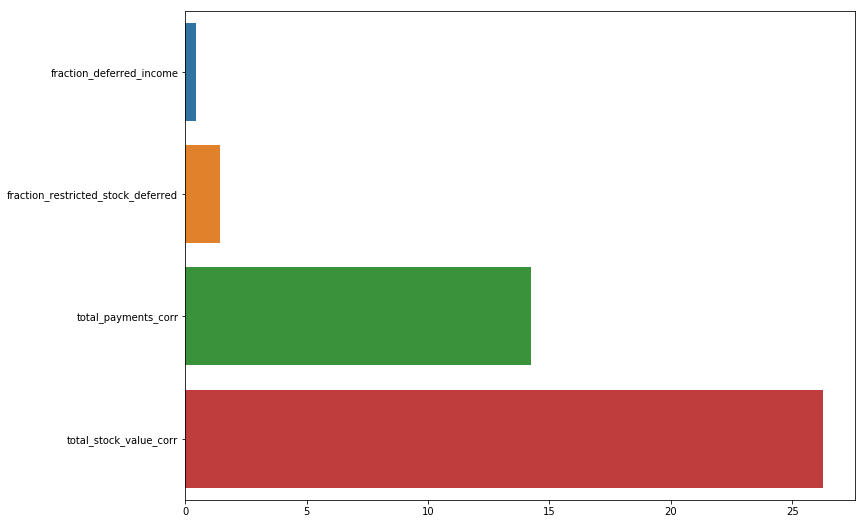

In [28]:
def plot_importance(df):
    y = df['poi']
    X = df.drop(['poi'], axis=1)

    #selector = SelectPercentile(percentile=100)
    selector = SelectKBest(k=2)
    a = selector.fit(X, y)
    plt.figure(figsize=(12,9))
    sns.barplot(y=X.columns, x=a.scores_)
plot_importance(df[features_list])

In [39]:
features_fractions_lost

['fraction_deferred_income', 'fraction_restricted_stock_deferred']

In [66]:
clf.predict([[-0.1, 0.0]])

array([1.])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
# The best kernel and hyperparameters are then available through the best_params_ variable:
print(grid_search.best_params_)
# {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [37]:
df['poi'].values

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])

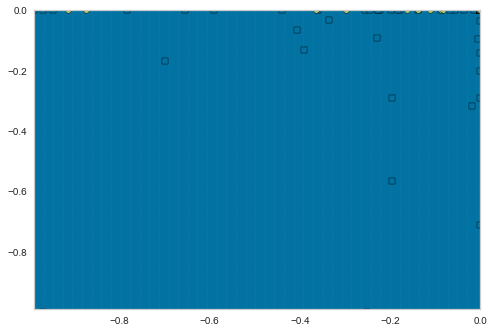

In [67]:
#from class_vis import prettyPicture
#prettyPicture(clf, features_test, labels_test)

#from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.contrib.classifier import DecisionViz

viz = DecisionViz(clf, title="Simple Decision Tree", features=features_fractions_lost, classes=['0.0', '1.0'])

viz.fit(df[features_fractions_lost].values, df['poi'].values)
viz.draw(df[features_fractions_lost].values, df['poi'].values)
# viz.draw(X_test, y_test)
# viz.poof(outpath="images/knn_decisionviz.png")

In [68]:
import scikitplot as skplt

ModuleNotFoundError: No module named 'scikitplot'

In [27]:
poi_communicator = (df['fraction_from_poi_to_this_person'] + df['fraction_from_this_person_to_poi']).sort_values(ascending=False)
poi_communicator.index
HTML(df.loc[poi_communicator.index].head(5).to_html())
#df_outliers = df[outliers]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,fraction_from_poi_to_this_person,fraction_from_this_person_to_poi
HUMPHREY GENE E,130724.0,128.0,2964506.0,3100224.0,NaN,NaN,gene.humphrey@enron.com,NaN,NaN,2282768.0,4994.0,10.0,2282768.0,17.0,NaN,17.0,0.0,NaN,119.0,NaN,NaN,0.078125,1.000000
SHERRICK JEFFREY B,NaN,613.0,NaN,NaN,NaN,NaN,jeffrey.sherrick@enron.com,NaN,NaN,1832468.0,NaN,39.0,1426469.0,25.0,NaN,18.0,0.0,NaN,583.0,405999.0,NaN,0.063622,0.720000
DONAHUE JR JEFFREY M,278601.0,865.0,NaN,875760.0,NaN,800000.0,jeff.donahue@enron.com,NaN,-300000.0,1080988.0,96268.0,188.0,765920.0,22.0,891.0,11.0,0.0,NaN,772.0,315068.0,NaN,0.217341,0.500000
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,kevin.hannon@enron.com,NaN,-3117011.0,6391065.0,34039.0,32.0,5538001.0,32.0,11350.0,21.0,1.0,1617011.0,1035.0,853064.0,NaN,0.030622,0.656250
GARLAND C KEVIN,231946.0,209.0,NaN,1566469.0,NaN,850000.0,kevin.garland@enron.com,NaN,NaN,896153.0,48405.0,10.0,636246.0,44.0,60814.0,27.0,0.0,375304.0,178.0,259907.0,NaN,0.047847,0.613636


### Considerations about using the features `from_poi_to_this_person` and `from_this_person_to_poi`
Because they contain derived information about the POI which in turn is the label. In case we want to identify a new POI, at least, this values must be update for all records.

['poi', 'salary', 'bonus', 'exercised_stock_options', 'total_stock_value']


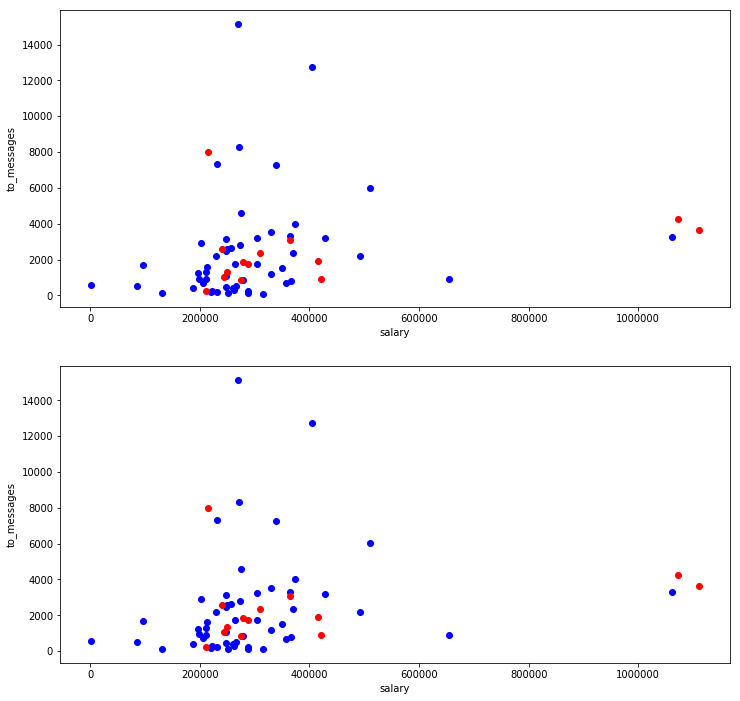

In [7]:

# fig, ax = plt.subplots()

def demo_plot_2features(ax, df):
    cols = df.columns[~df.columns.isin(['poi'])]
    def plot_s(d, color=None, label=None):
        X = d[cols[0]]
        Y = d[cols[1]]
        ax.plot(X,Y, 'o', marker='o', color=color)# color, label=label)
    d_npoi = df[df['poi'] == False]
    plot_s(d_npoi, color='blue', label='not POI')
    
    d_poi = df[df['poi'] == True]
    plot_s(d_poi, color='red', label='is POI')
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])

#fig = plt.figure(figsize=(12,9))
#(ax1, ax2, ax3) = fig.add_subplot(3, 1, 1)
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,12))
features2plot = ['poi'] + features_financial_basic + features_financial_stock
print(features2plot)
pnum = 2 #len(test_countries)
fig, ax = plt.subplots(pnum, figsize=(12,12))

for pos in range(pnum):
    demo_plot_2features(ax[pos], df)
    #ax[pos].plot([ testi[pos]['Median GDP per capita'], testi[pos]['GDP per capita'] ], [0,0], 'o')
#ax[pnum-1].set_xlabel("Categories (bins) of income in $")

plt.show()

In [18]:
print("Number of records in the dataset: {}".format(len(df.index)))

Number of records in the dataset: 146


The dataset contains 146

> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

> What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

>  What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

> What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

> Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]